LSTM + Attention Mechanism for clustering latent dim

In [2]:
x = list(range(10))
x

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [3]:
y = list(reversed(range(10)))
y

[9, 8, 7, 6, 5, 4, 3, 2, 1, 0]

In [ ]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import os
import tensorflow as tf
from tensorflow.keras import Model, Input, regularizers
from tensorflow.keras.layers import (
    LSTM, Dense, Flatten, Activation, RepeatVector, Permute, Multiply, 
    Lambda, Dropout, BatchNormalization, TimeDistributed
)
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.layers import Layer

In [5]:

def ReduceSumLayer(axis=1, keepdims=False, name=None):
    """
    Returns a Keras layer that sums its input along `axis`.
    
    Usage in your model:
        context_vector = ReduceSumLayer(axis=1)(weighted)
    """
    return Lambda(
        lambda x: tf.reduce_sum(x, axis=axis, keepdims=keepdims),
        name=name
    )


In [ ]:
class LSTMAttentionAutoencoder:
    def __init__(self, 
                 input_shape=(102, 2),
                 latent_dim=16, 
                 lstm_units=[64, 32],
                 dropout_rate=0.3, 
                 l2_reg=1e-4):
        self.input_shape = input_shape
        self.latent_dim = latent_dim
        self.lstm_units = lstm_units
        self.dropout_rate = dropout_rate
        self.l2_reg = l2_reg
        self.model, self.encoder = self._build_model()
    
    def _attention_block(self, lstm_out):
        attention = Dense(1, activation='tanh')(lstm_out)
        attention = Flatten()(attention)
        attention = Activation('softmax')(attention)
        attention = RepeatVector(self.lstm_units[-1])(attention)
        attention = Permute([2, 1])(attention)
        weighted = Multiply()([lstm_out, attention])
        context_vector = ReduceSumLayer()(weighted)
        return context_vector

    def _build_model(self):
        # Encoder
        inputs = Input(shape=self.input_shape)
        x = inputs
        for units in self.lstm_units:
            x = LSTM(units, return_sequences=True, kernel_regularizer=regularizers.l2(self.l2_reg))(x)
            x = BatchNormalization()(x)
            x = Dropout(self.dropout_rate)(x)
        context_vector = self._attention_block(x)
        x = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(self.l2_reg))(context_vector)
        x = BatchNormalization()(x)
        x = Dropout(self.dropout_rate)(x)
        latent = Dense(self.latent_dim, name='latent_vector')(x)

        # Decoder
        x = Dense(64, activation='relu')(latent)
        x = RepeatVector(self.input_shape[0])(x)
        for units in reversed(self.lstm_units):
            x = LSTM(units, return_sequences=True)(x)
            x = BatchNormalization()(x)
            x = Dropout(self.dropout_rate)(x)
        outputs = TimeDistributed(Dense(self.input_shape[1]))(x)

        autoencoder = Model(inputs, outputs, name="LSTM_Attention_Autoencoder")
        encoder = Model(inputs, latent, name="Encoder")
        return autoencoder, encoder

    def compile(self, learning_rate=1e-3):
        self.model.compile(optimizer=Adam(learning_rate), loss='mse')

    def train(self, X_train, epochs=50, batch_size=16, verbose=1):
        self.model.fit(X_train, X_train, epochs=epochs, batch_size=batch_size, verbose=verbose)

    def get_latent_vectors(self, X):
        return self.encoder.predict(X)

    def summary(self):
        self.model.summary()


In [4]:
# Loading data
data = pd.read_csv(r"C:\Users\Admin\Desktop\CP\Data\processed\final_processed\dataset_final.csv")
data

,Patient ID,aSagH_0,aSagH_2,aSagH_4,aSagH_6,aSagH_8,aSagH_10,aSagH_12,aSagH_14,aSagH_16,...,aSagK_82,aSagK_84,aSagK_86,aSagK_88,aSagK_90,aSagK_92,aSagK_94,aSagK_96,aSagK_98,aSagK_100
0,DS_A_105,51.408820,50.933351,50.243717,49.185245,47.719346,45.910284,43.859224,41.645014,39.300897,...,51.372876,45.154620,38.591292,32.102879,26.155350,21.227770,17.730555,15.902838,15.736829,16.955275
1,DS_A_111,37.957060,36.832004,35.150579,33.196743,31.149266,29.142866,27.296597,25.665230,23.454627,...,54.336050,48.689244,42.710607,36.123512,29.556417,23.620913,18.962990,16.150704,15.001421,14.935191
2,DS_A_113,34.543478,33.568140,32.195900,30.524125,28.655009,26.635878,24.472867,22.176569,19.786189,...,34.661066,28.846462,23.463793,18.915385,15.390320,12.947345,11.602520,11.357084,12.179563,13.968662
3,DS_A_127,39.280994,37.954086,37.565979,37.898317,36.484441,34.009033,31.881341,29.772771,27.657092,...,38.296512,33.717704,28.803688,23.955544,19.446595,15.524868,12.601406,10.841740,10.075318,10.333831
4,DS_A_157,34.197200,35.312177,36.060747,35.624389,34.566009,33.649150,32.641324,31.035173,28.675158,...,61.099208,57.061305,51.597262,44.833063,37.268508,29.703760,22.975866,17.964445,15.561585,16.119956
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
913,DS_D_163,31.012758,30.489488,29.960665,29.406627,28.811238,28.167355,26.862515,25.444343,23.877094,...,57.721646,52.870670,46.778846,40.000741,33.289863,27.441837,23.089373,20.526996,19.646060,20.010183
914,DS_D_164,40.993449,40.389380,39.648925,38.751212,37.009590,34.929431,33.696487,33.353748,32.714896,...,47.276169,44.219407,40.725512,36.413834,31.563812,26.488436,22.229380,19.698101,19.337913,20.868087
915,DS_D_165,20.887456,19.671651,18.318401,16.844711,15.291666,13.726765,11.991060,10.426842,9.052839,...,37.596017,32.702072,27.110246,21.200292,15.439498,10.258086,5.990952,2.765574,0.482009,-1.014051
916,DS_D_166,32.837266,32.394426,32.237961,31.148673,28.982616,27.076962,26.136772,25.892548,25.181799,...,60.415707,55.501876,49.256081,42.360675,35.737430,30.014115,25.111013,20.659160,17.507859,17.263962


In [8]:
# Split into train and test data
unique_patients = data['Patient ID'].unique()
train_patients, test_patients = train_test_split(unique_patients, test_size=0.30, random_state=7)
train_df = data[data['Patient ID'].isin(train_patients)].reset_index(drop=True)
test_df = data[data['Patient ID'].isin(test_patients)].reset_index(drop=True)
print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)
print("Train patients:", train_df['Patient ID'].nunique())
print("Test patients:", test_df['Patient ID'].nunique())


Train shape: (642, 103)
Test shape: (276, 103)
Train patients: 642
Test patients: 276


In [9]:
# Fill NaNs in train_df and test_df
train_df = train_df.interpolate(axis=0).fillna(method='bfill').fillna(method='ffill')
test_df = test_df.interpolate(axis=0).fillna(method='bfill').fillna(method='ffill')
hip_cols = [col for col in train_df.columns if col.startswith('aSagH_')]
knee_cols = [col for col in train_df.columns if col.startswith('aSagK_')]

patient_sequences = []
patient_ids = []
for pid in train_df['Patient ID'].unique():
    hip_data = train_df[train_df['Patient ID'] == pid][hip_cols].values.flatten()
    knee_data = train_df[train_df['Patient ID'] == pid][knee_cols].values.flatten()
    if len(hip_data) == 51 and len(knee_data) == 51:
        patient_sequence = np.stack([knee_data, hip_data], axis=1)
        patient_sequences.append(patient_sequence)
        patient_ids.append(pid)
X_train = np.array(patient_sequences)
X_train_patient_ids = np.array(patient_ids)
print("Patient sequences shape:", X_train.shape)
print("Patient IDs shape:", X_train_patient_ids.shape)


C:\Users\Admin\AppData\Local\Temp\ipykernel_12224\1148850844.py:2: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  train_df = train_df.interpolate(axis=0).fillna(method='bfill').fillna(method='ffill')
C:\Users\Admin\AppData\Local\Temp\ipykernel_12224\1148850844.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_df = train_df.interpolate(axis=0).fillna(method='bfill').fillna(method='ffill')
C:\Users\Admin\AppData\Local\Temp\ipykernel_12224\1148850844.py:3: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  test_df = test_df.interpolate(axis=0).fillna(method='bfill').fillna(method='ffill')
C:\Users\Admin\AppData\Local\Temp\ipykernel_12224\1148850844.

Patient sequences shape: (642, 51, 2)
Patient IDs shape: (642,)


In [ ]:
hip_cols = [col for col in test_df.columns if col.startswith('aSagH_')]
knee_cols = [col for col in test_df.columns if col.startswith('aSagK_')]

patient_sequences = []
patient_ids = []
for pid in test_df['Patient ID'].unique():
    hip_data = test_df[test_df['Patient ID'] == pid][hip_cols].values.flatten()
    knee_data = test_df[test_df['Patient ID'] == pid][knee_cols].values.flatten()
    if len(hip_data) == 51 and len(knee_data) == 51:
        patient_sequence = np.stack([knee_data, hip_data], axis=1)
        patient_sequences.append(patient_sequence)
        patient_ids.append(pid)
X_test = np.array(patient_sequences)
X_test_patient_ids = np.array(patient_ids)
print("Patient sequences shape:", X_test.shape)
print("Patient IDs shape:", X_test_patient_ids.shape)

Patient sequences shape: (276, 51, 2)
Patient IDs shape: (276,)


In [ ]:
# Scaling the data
X_train_reshaped = X_train.reshape(-1, X_train.shape[-1])
X_test_reshaped = X_test.reshape(-1, X_test.shape[-1])
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_reshaped)
X_test_scaled = scaler.transform(X_test_reshaped)
X_train = X_train_scaled.reshape(X_train.shape)
X_test = X_test_scaled.reshape(X_test.shape)

In [98]:
import keras_tuner as kt

def build_model(hp):
    latent_dim = hp.Int('latent_dim', min_value=8, max_value=64, step=8)
    lstm_units_1 = hp.Int('lstm_units_1', min_value=16, max_value=128, step=16)
    lstm_units_2 = hp.Int('lstm_units_2', min_value=8, max_value=64, step=8)
    lstm_units_3 = hp.Int('lstm_units_3', min_value=8, max_value=64, step=8)
    dropout_rate = hp.Float('dropout_rate', min_value=0.15, max_value=0.55, step=0.1)
    l2_reg = hp.Float('l2_reg', min_value=1e-5, max_value=1e-3, sampling='log')
    model = LSTMAttentionAutoencoder(
        input_shape=(51, 2),
        latent_dim=latent_dim,
        lstm_units=[lstm_units_1, lstm_units_2,lstm_units_3],
        dropout_rate=dropout_rate,
        l2_reg=l2_reg
    )
    model.compile()
    return model.model


In [99]:
tuner = kt.BayesianOptimization(
    build_model,
    objective='val_loss',
    max_trials=15,
    executions_per_trial=2,
    directory=r'C:\Users\Admin\Desktop\CP\Outputs\HP Tuning\tuner_results',
    project_name='bayesian_tuning_lstm_attention_autoencoder'
)
tuner.search(X_train, X_train, epochs=30, batch_size=16, validation_split=0.3, verbose=1)


Trial 15 Complete [00h 08m 12s]
val_loss: 0.05348565988242626

Best val_loss So Far: 0.02345571294426918
Total elapsed time: 01h 34m 50s


Trial 00 val_loss history length: 1
Trial 01 val_loss history length: 1
Trial 02 val_loss history length: 1
Trial 03 val_loss history length: 1
Trial 04 val_loss history length: 1
Trial 05 val_loss history length: 1
Trial 06 val_loss history length: 1
Trial 07 val_loss history length: 1
Trial 08 val_loss history length: 1
Trial 09 val_loss history length: 1
Trial 10 val_loss history length: 1
Trial 11 val_loss history length: 1
Trial 12 val_loss history length: 1
Trial 13 val_loss history length: 1
Trial 14 val_loss history length: 1


C:\Users\Admin\AppData\Local\Temp\ipykernel_16256\883519946.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


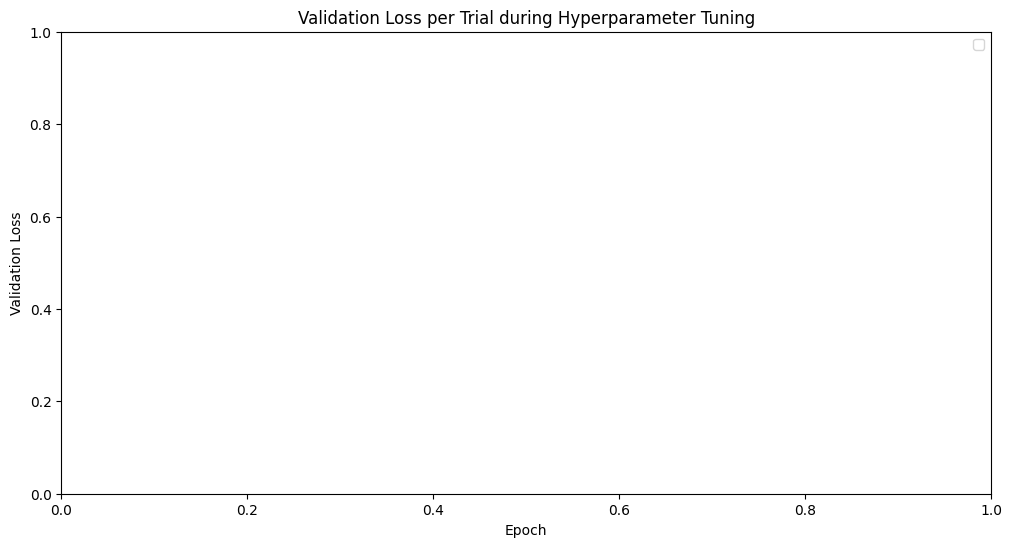

In [ ]:
trials = tuner.oracle.trials
plt.figure(figsize=(12, 6))
for trial_id, trial in trials.items():
    history_objs = trial.metrics.get_history('val_loss')
    print(f"Trial {trial_id} val_loss history length:", len(history_objs))  # Debug print
    history = [h.value for h in history_objs]
    if len(history) > 1:
        plt.plot(range(1, len(history)+1), history, label=f'Trial {trial_id}')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.title('Validation Loss per Trial during Hyperparameter Tuning')
plt.legend()
plt.show()

In [104]:
best_model = tuner.get_best_models(num_models=1)[0]
best_model.save(r'C:\Users\Admin\Desktop\CP\Outputs\HP Tuning\model\best_lstm_attention_autoencoder.h5')
best_model.save(r'C:\Users\Admin\Desktop\CP\Outputs\HP Tuning\model\best_lstm_attention_autoencoder.keras')


c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 86 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [105]:
best_hp = tuner.get_best_hyperparameters()[0]
print(best_hp.values)

{'latent_dim': 40, 'lstm_units_1': 96, 'lstm_units_2': 32, 'lstm_units_3': 16, 'dropout_rate': 0.15, 'l2_reg': 5.353757600664288e-05}


9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 357ms/step


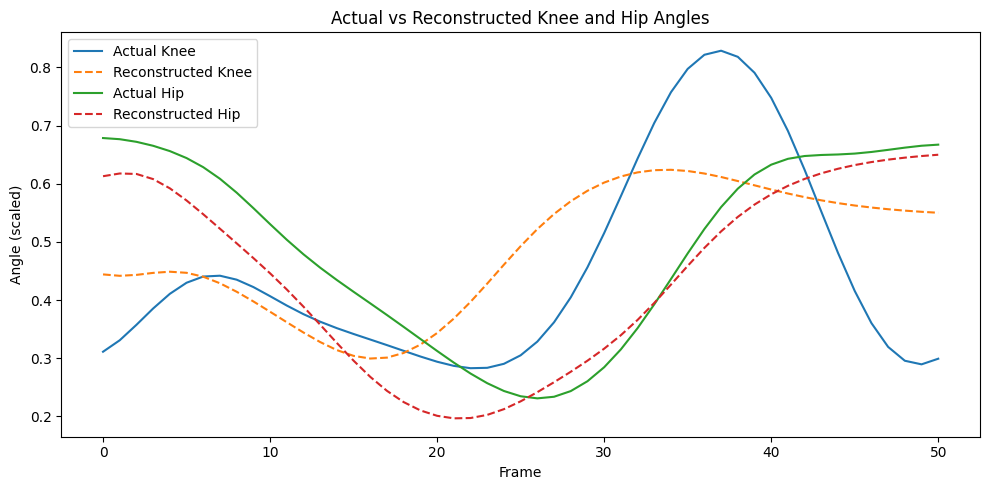

In [106]:
import matplotlib.pyplot as plt
import numpy as np

X_test_pred = best_model.predict(X_test)
idx = 0  # test patient index
actual = X_test[idx]
reconstructed = X_test_pred[idx]
plt.figure(figsize=(10, 5))
plt.plot(actual[:, 0], label='Actual Knee')
plt.plot(reconstructed[:, 0], label='Reconstructed Knee', linestyle='--')
plt.plot(actual[:, 1], label='Actual Hip')
plt.plot(reconstructed[:, 1], label='Reconstructed Hip', linestyle='--')
plt.title('Actual vs Reconstructed Knee and Hip Angles')
plt.xlabel('Frame')
plt.ylabel('Angle (scaled)')
plt.legend()
plt.tight_layout()
plt.savefig(r'C:\Users\Admin\Desktop\CP\Outputs\results\plots\actual_vs_reconstructed_single.png')
plt.show()


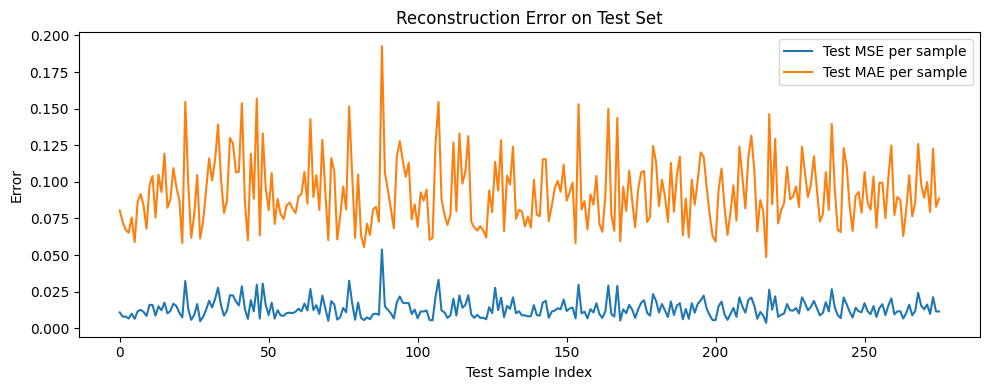

In [107]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse_list = [mean_squared_error(X_test[i], X_test_pred[i]) for i in range(len(X_test))]
mae_list = [mean_absolute_error(X_test[i], X_test_pred[i]) for i in range(len(X_test))]
plt.figure(figsize=(10, 4))
plt.plot(mse_list, label='Test MSE per sample')
plt.plot(mae_list, label='Test MAE per sample')
plt.xlabel('Test Sample Index')
plt.ylabel('Error')
plt.title('Reconstruction Error on Test Set')
plt.legend()
plt.tight_layout()
plt.savefig(r'C:\Users\Admin\Desktop\CP\Outputs\results\plots\test_reconstruction_error.png')
plt.show()


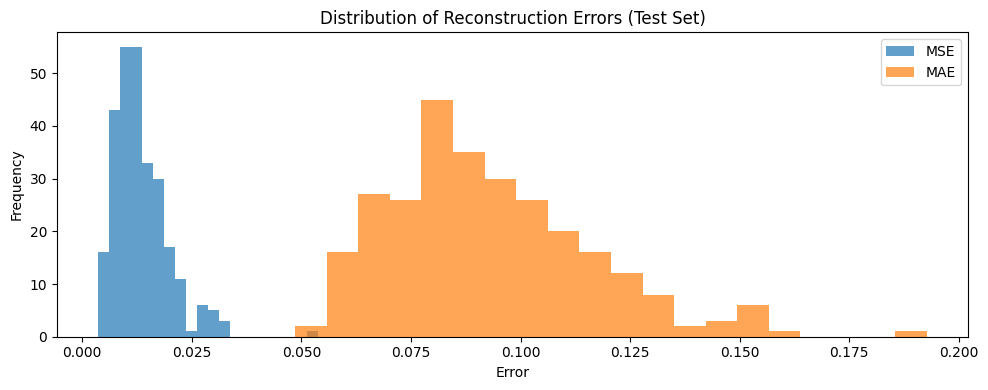

In [108]:
plt.figure(figsize=(10, 4))
plt.hist(mse_list, bins=20, alpha=0.7, label='MSE')
plt.hist(mae_list, bins=20, alpha=0.7, label='MAE')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.title('Distribution of Reconstruction Errors (Test Set)')
plt.legend()
plt.tight_layout()
plt.savefig(r'C:\Users\Admin\Desktop\CP\Outputs\results\plots\test_error_histogram.png')
plt.show()


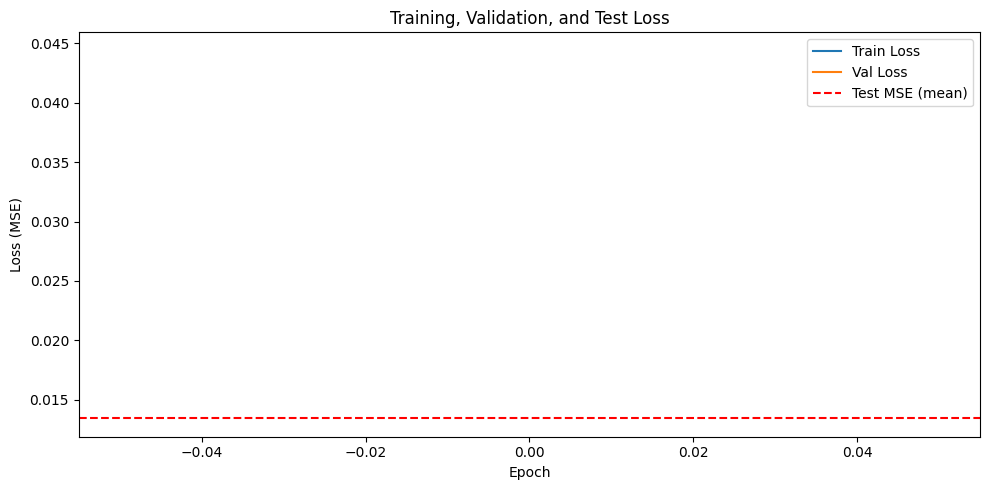

In [111]:
plt.figure(figsize=(10, 5))
# If you used KerasTuner, 'history' is not a History object but a list of trial histories.
# To plot the best trial's loss, get the best trial from the tuner:
best_trial = tuner.oracle.get_best_trials(num_trials=1)[0]
train_loss = [m.value for m in best_trial.metrics.get_history('loss')]
plt.plot(train_loss, label='Train Loss')
val_loss = [m.value for m in best_trial.metrics.get_history('val_loss')]
plt.plot(val_loss, label='Val Loss')
plt.axhline(np.mean(mse_list), color='red', linestyle='--', label='Test MSE (mean)')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training, Validation, and Test Loss')
plt.legend()
plt.tight_layout()
plt.savefig(r'C:\Users\Admin\Desktop\CP\Outputs\results\plots\loss_curve_with_test.png')
plt.show()


In [ ]:
from tensorflow.keras.models import load_model

#import the .keras model

model = load_model(r'C:\Users\Admin\Desktop\CP\Outputs\HP Tuning\model\best_lstm_attention_autoencoder.keras', custom_objects={'ReduceSumLayer': ReduceSumLayer})

c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 44 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [13]:
from tensorflow.keras.models import Model
import joblib

# Use the loaded model
encoder_input = model.input
latent_output = model.get_layer('latent_vector').output
encoder = Model(encoder_input, latent_output)

X_train_latent = encoder.predict(X_train)
X_test_latent = encoder.predict(X_test)
print("Train latent shape:", X_train_latent.shape)
print("Test latent shape:", X_test_latent.shape)

from sklearn.mixture import GaussianMixture
n_clusters = 4
gmm = GaussianMixture(n_components=n_clusters, random_state=42)
clusters = gmm.fit_predict(X_train_latent)
print("Cluster assignments for train set:", clusters)

# Save the GMM model
joblib.dump(gmm, r'C:\Users\Admin\Desktop\CP\Outputs\results\gmm_model\gmm_model.joblib')


21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Train latent shape: (642, 40)
Test latent shape: (276, 40)
Train latent shape: (642, 40)
Test latent shape: (276, 40)
Cluster assignments for train set: [2 2 2 2 2 2 2 0 0 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 0 0 2 2 2 2 2 2 0
 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 3 0 3 0 0 0 0 0 1 0 2 0 2 2 1 3 3 1 3 1
 0 2 3 3 2 3 3 0 1 0 0 3 3 1 0 3 3 0 0 3 3 3 3 1 3 3 3 1 1 3 3 1 3 0 3 3 3
 3 1 3 1 1 3 3 0 3 3 3 1 0 0 1 2 0 0 2 0 0 3 0 0 1 3 0 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 0 0 0 2 2 2 2 2 3 3 2 0 1 2 1 0 2 1 2 0 1 2 2 0 0 2 0 2 0 2 0 0 0
 0 2 2 2 0 2 0 1 0 2 2 0 0 3 0 2 3 3 0 0 0 3 2 2 3 0 3 2 2 2 1 0 3 0 2 0 2
 3 2 0 3 1 3 3 0 2 1 2 3 3 0 2 2 2 0 0 0 2 1 3 2 2 2 1 1 3 3 0 0 1 0 1 0 3
 3 0 0 0 2 0 2 2 2 0 0 0 2 2 2 0 2 2 2 2 0 0 3 0 0 2 2 2 0 0 0 0 3 2 0 0 0
 2 2 0 0 0 3 3 1 2 0 2 0 3 1 1 2 0 2 2 1 0 2 2 1 2 3 2 0 2 2 2 0 2 3 1 0 0
 2 3 2 0 2 1 0 2

['C:\\Users\\Admin\\Desktop\\CP\\Outputs\\results\\gmm_model\\gmm_model.joblib']

In [ ]:

from tensorflow.keras.models import Model

# Rebuild the encoder from the best_model
encoder_input = best_model.input
latent_output = best_model.get_layer('latent_vector').output
encoder = Model(encoder_input, latent_output)

X_train_latent = encoder.predict(X_train)
X_test_latent = encoder.predict(X_test)
print("Train latent shape:", X_train_latent.shape)
print("Test latent shape:", X_test_latent.shape)

from sklearn.mixture import GaussianMixture
n_clusters = 4
gmm = GaussianMixture(n_components=n_clusters, random_state=42)
clusters = gmm.fit_predict(X_train_latent)
print("Cluster assignments for train set:", clusters)


21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Train latent shape: (642, 40)
Test latent shape: (276, 40)
Cluster assignments for train set: [2 2 2 2 2 2 2 0 0 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 0 0 2 2 2 2 2 2 0
 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 3 0 3 0 0 0 0 0 1 0 2 0 2 2 1 3 3 1 3 1
 0 2 3 3 2 3 3 0 1 0 0 3 3 1 0 3 3 0 0 3 3 3 3 1 3 3 3 1 1 3 3 1 3 0 3 3 3
 3 1 3 1 1 3 3 0 3 3 3 1 0 0 1 2 0 0 2 0 0 3 0 0 1 3 0 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 0 0 0 2 2 2 2 2 3 3 2 0 1 2 1 0 2 1 2 0 1 2 2 0 0 2 0 2 0 2 0 0 0
 0 2 2 2 0 2 0 1 0 2 2 0 0 3 0 2 3 3 0 0 0 3 2 2 3 0 3 2 2 2 1 0 3 0 2 0 2
 3 2 0 3 1 3 3 0 2 1 2 3 3 0 2 2 2 0 0 0 2 1 3 2 2 2 1 1 3 3 0 0 1 0 1 0 3
 3 0 0 0 2 0 2 2 2 0 0 0 2 2 2 0 2 2 2 2 0 0 3 0 0 2 2 2 0 0 0 0 3 2 0 0 0
 2 2 0 0 0 3 3 1 2 0 2 0 3 1 1 2 0 2 2 1 0 2 2 1 2 3 2 0 2 2 2 0 2 3 1 0 0
 2 3 2 0 2 1 0 2 0 0 3 2 2 2 1 2 1 0 2 0 0 1 1 3 3 2 0 0 2 2 0 1 2 0 0 2 2
 2 0 2 3 2 0 0 0 1 0 0 0 0 0 0 2 2 2 0 2 3 2 1 3 0 0 2 0 2 2 2 0 2 0 0 3 0
 3 

In [115]:
import pandas as pd

# Get GMM probabilities for each cluster
probs = gmm.predict_proba(X_train_latent)

# Create DataFrame with Patient ID and cluster probabilities
cluster_prob_df = pd.DataFrame(
    probs,
    columns=['Cluster0', 'Cluster1', 'Cluster2', 'Cluster3']
)
cluster_prob_df.insert(0, 'Patient ID', X_train_patient_ids)

print(cluster_prob_df.head())
cluster_prob_df.to_csv(r'C:\Users\Admin\Desktop\CP\Outputs\results\train_patient_clusters.csv', index=False)

  Patient ID      Cluster0  Cluster1  Cluster2  Cluster3
0   DS_A_105  1.073515e-34       0.0       1.0       0.0
1   DS_A_111  0.000000e+00       0.0       1.0       0.0
2   DS_A_113  0.000000e+00       0.0       1.0       0.0
3   DS_A_127  0.000000e+00       0.0       1.0       0.0
4   DS_A_157  6.506722e-45       0.0       1.0       0.0


In [117]:
all_latent = np.concatenate([X_train_latent, X_test_latent], axis=0)
probs = gmm.predict_proba(all_latent)

# Create DataFrame with Patient ID and cluster probabilities
all_patient_ids = np.concatenate([X_train_patient_ids, X_test_patient_ids])
cluster_prob_df_all = pd.DataFrame(
    probs,
    columns=['Cluster0', 'Cluster1', 'Cluster2', 'Cluster3']
)
cluster_prob_df_all.insert(0, 'Patient ID', all_patient_ids)

print(cluster_prob_df_all.head())
cluster_prob_df_all.to_csv(r'C:\Users\Admin\Desktop\CP\Outputs\results\all_patient_clusters.csv', index=False)

  Patient ID      Cluster0  Cluster1  Cluster2  Cluster3
0   DS_A_105  1.073515e-34       0.0       1.0       0.0
1   DS_A_111  0.000000e+00       0.0       1.0       0.0
2   DS_A_113  0.000000e+00       0.0       1.0       0.0
3   DS_A_127  0.000000e+00       0.0       1.0       0.0
4   DS_A_157  6.506722e-45       0.0       1.0       0.0


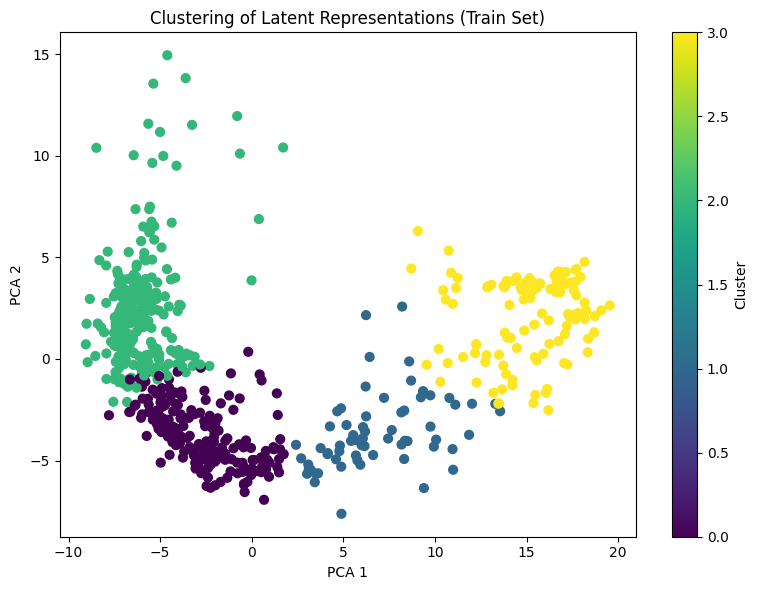

In [118]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
pca = PCA(n_components=2)
latent_2d = pca.fit_transform(X_train_latent)
plt.figure(figsize=(8,6))
plt.scatter(latent_2d[:,0], latent_2d[:,1], c=clusters, cmap='viridis', s=40)
plt.title('Clustering of Latent Representations (Train Set)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.colorbar(label='Cluster')
plt.tight_layout()
plt.savefig(r'C:\Users\Admin\Desktop\CP\Outputs\results\plots\train_latent_clustering.png')
plt.show()


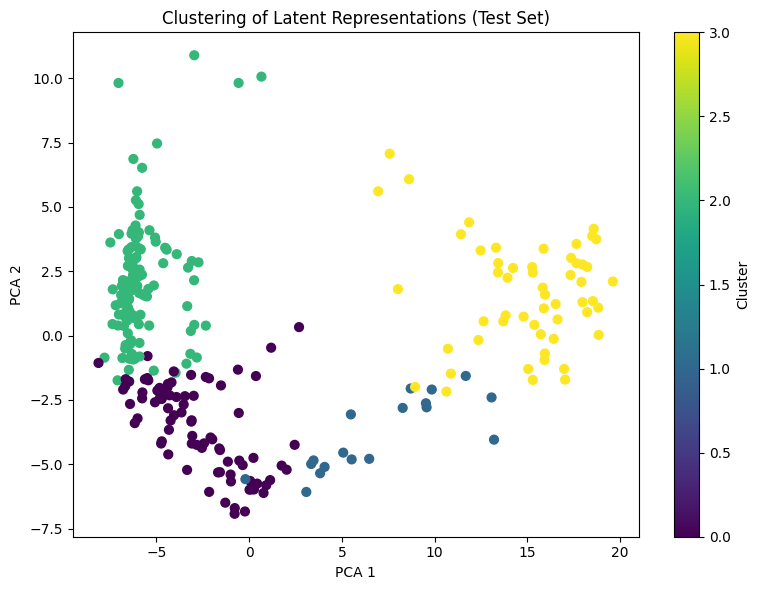

In [120]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
pca = PCA(n_components=2)
test_clusters = gmm.predict(X_test_latent)
latent_2d = pca.fit_transform(X_test_latent)
plt.figure(figsize=(8,6))
plt.scatter(latent_2d[:,0], latent_2d[:,1], c=test_clusters, cmap='viridis', s=40)
plt.title('Clustering of Latent Representations (Test Set)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.colorbar(label='Cluster')
plt.tight_layout()
plt.savefig(r'C:\Users\Admin\Desktop\CP\Outputs\results\plots\test_latent_clustering.png')
plt.show()


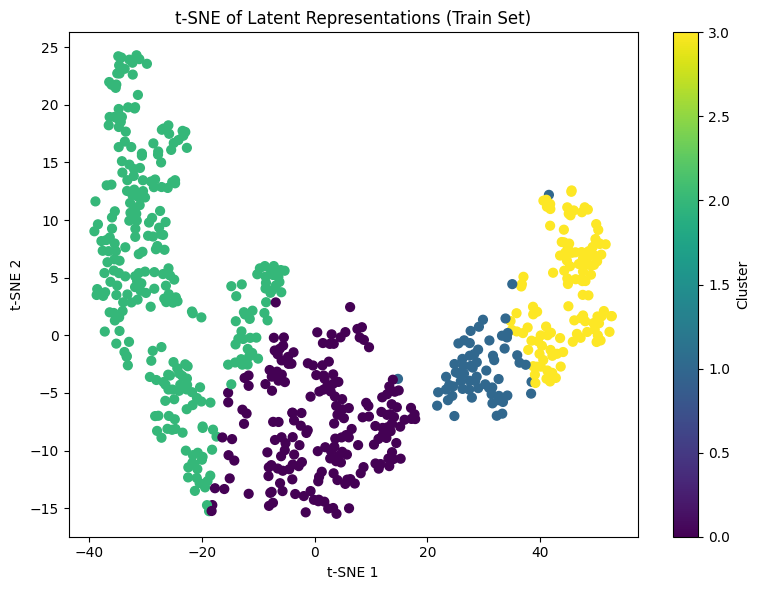

In [122]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
latent_tsne = tsne.fit_transform(X_train_latent)
plt.figure(figsize=(8,6))
plt.scatter(latent_tsne[:,0], latent_tsne[:,1], c=clusters, cmap='viridis', s=40)
plt.title('t-SNE of Latent Representations (Train Set)')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.colorbar(label='Cluster')
plt.tight_layout()
plt.savefig(r'C:\Users\Admin\Desktop\CP\Outputs\results\plots\latent_clustering_tsne.png')
plt.show()


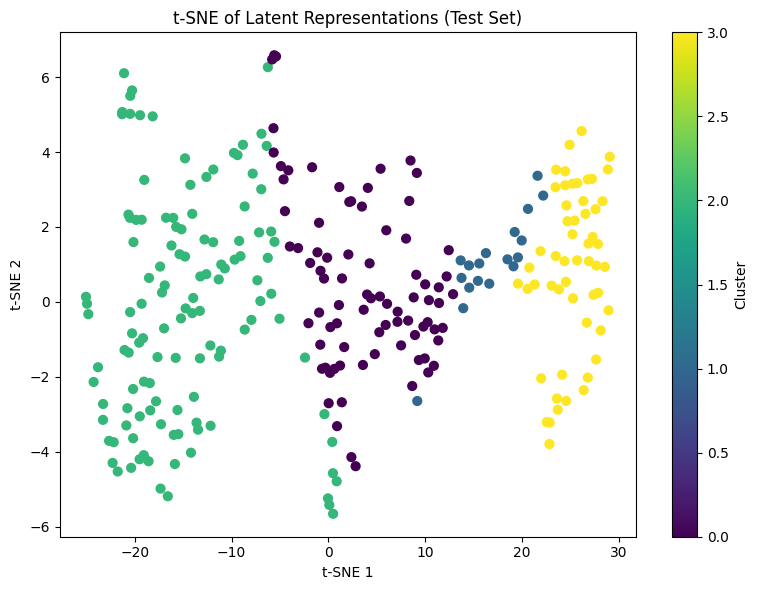

In [121]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
latent_tsne_test = tsne.fit_transform(X_test_latent)
test_clusters = gmm.predict(X_test_latent)

plt.figure(figsize=(8,6))
plt.scatter(latent_tsne_test[:,0], latent_tsne_test[:,1], c=test_clusters, cmap='viridis', s=40)
plt.title('t-SNE of Latent Representations (Test Set)')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.colorbar(label='Cluster')
plt.tight_layout()
plt.savefig(r'C:\Users\Admin\Desktop\CP\Outputs\results\plots\test_latent_clustering_tsne.png')
plt.show()


c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


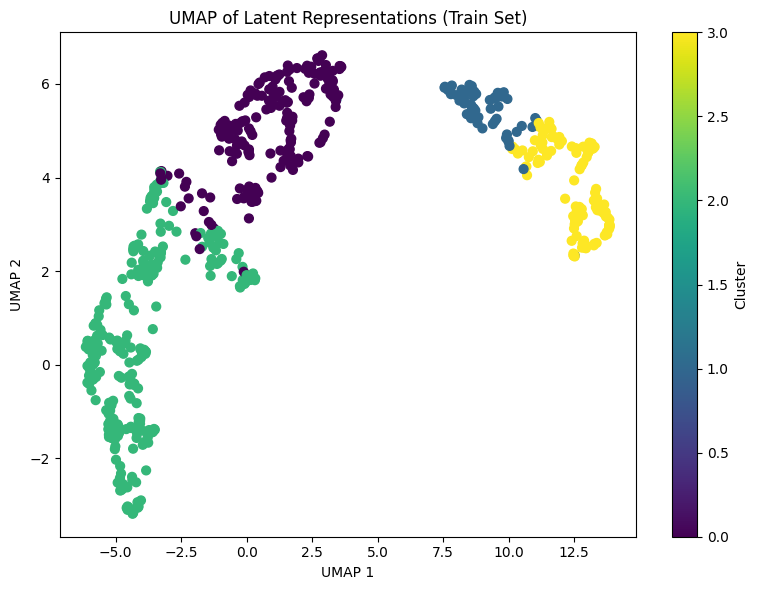

In [124]:
import umap
umap_reducer = umap.UMAP(n_components=2, random_state=42)
latent_umap = umap_reducer.fit_transform(X_train_latent)
plt.figure(figsize=(8,6))
plt.scatter(latent_umap[:,0], latent_umap[:,1], c=clusters, cmap='viridis', s=40)
plt.title('UMAP of Latent Representations (Train Set)')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.colorbar(label='Cluster')
plt.tight_layout()
plt.savefig(r'C:\Users\Admin\Desktop\CP\Outputs\results\plots\latent_clustering_umap.png')
plt.show()


c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


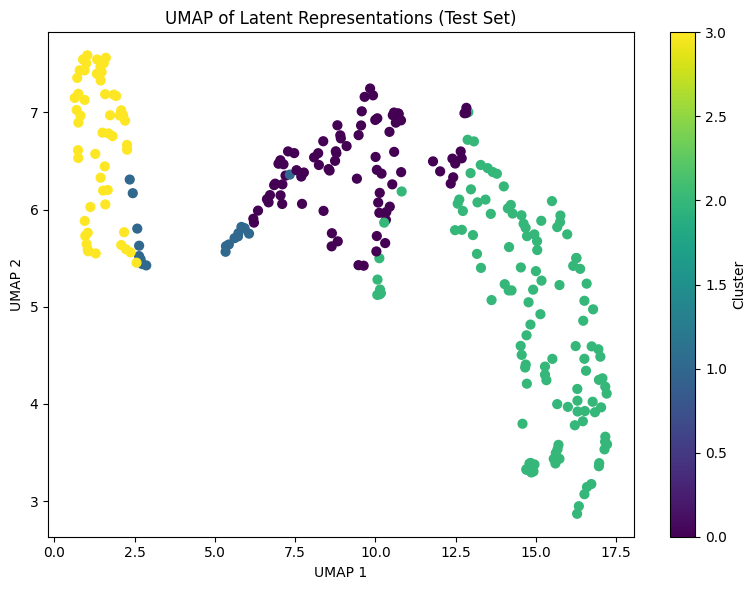

In [123]:
import umap
umap_reducer = umap.UMAP(n_components=2, random_state=42)
latent_umap_test = umap_reducer.fit_transform(X_test_latent)
test_clusters = gmm.predict(X_test_latent)
plt.figure(figsize=(8,6))
plt.scatter(latent_umap_test[:,0], latent_umap_test[:,1], c=test_clusters, cmap='viridis', s=40)
plt.title('UMAP of Latent Representations (Test Set)')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.colorbar(label='Cluster')
plt.tight_layout()
plt.savefig(r'C:\Users\Admin\Desktop\CP\Outputs\results\plots\test_latent_clustering_umap.png')
plt.show()
